In [75]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from getdist import plots, MCSamples
import emcee
import main
import random
plt.style.use("style.mplstyle")

### Graficador

In [84]:
pas = pd.DataFrame(pd.read_csv("historico2023_2024.csv"))
antepas = pd.DataFrame(pd.read_csv("historico2022_2023.csv"))
actual = pd.DataFrame(pd.read_csv("actual2024_2025.csv"))

In [85]:
pas.index = pas["Jugador"]
pas = pas.drop(labels=["Jugador","TOTAL","J0","COM","DIV","FC","SB","TOTAL"],axis=1)
antepas.index= antepas["Jugador"]
antepas = antepas.drop(labels=["Jugador","TOTAL","J0","COM","DIV","FC","SB","TOTAL"],axis=1)
actual.index = actual["Jugador"]
actual = actual.drop(labels=["Jugador","TOTAL","COM","DIV","FC","SB","TOTAL"],axis=1)

In [89]:
pas.T["Rodrigo"].cumsum()

J1       6
J2      17
J3      24
J4      35
J5      42
J6      51
J7      58
J8      69
J9      75
J10     80
J11     90
J12    101
J13    109
J14    117
J15    127
J16    136
J17    146
J18    155
Name: Rodrigo, dtype: int64

In [91]:
pas.T["Rodrigo"].cumsum().to_numpy()

array([  6,  17,  24,  35,  42,  51,  58,  69,  75,  80,  90, 101, 109,
       117, 127, 136, 146, 155])

### MCMC 

In [54]:
campaña = pd.DataFrame(pd.read_csv("actual2024_2025.csv"))
campaña.index = campaña["Jugador"]
maximos = campaña.T["Nmax"][2:-5].to_numpy()
actual = campaña.drop(labels=["Jugador","J0","COM","DIV","FC","SB","TOTAL"],axis=1)

In [55]:
reader = emcee.backends.HDFBackend("Backends/4Sept2024.h5",read_only=True)
chains = reader.get_chain(flat=True)

In [56]:
np.random.seed(1001)
ind = np.random.randint(len(chains),size=10000)
sample = chains[ind[0]]

In [57]:
df = main.CreateMock(sample,jornada=2,maximos=maximos).fill()

In [58]:
df.loc["J1"] = actual["J1"]
df.loc["J2"] = actual["J2"]
#df = df.reset_index(drop=True)

In [59]:
winners = []
for i in ind:
    sample = chains[i]
    df = main.CreateMock(sample,jornada=2,maximos=maximos).fill()
    df.loc["J1"] = actual["J1"]
    df.loc["J2"] = actual["J2"]
    winner = df.sum().idxmax()
    winners.append(winner)

In [60]:
wp = pd.Series(winners).value_counts(sort=True)

In [61]:
wp

Fer           4215
Angel         2250
Mickey        1250
Gabrielito     928
Pao            838
Rodrigo        247
Juvs           234
Lety            22
Liz             10
Gaby             4
Juan-Angel       2
Name: count, dtype: int64

In [70]:
colors = ["darkgoldenrod","darkviolet","black","blue","cornflowerblue","deepskyblue","dimgray","maroon","yellow","hotpink","darkseagreen"]

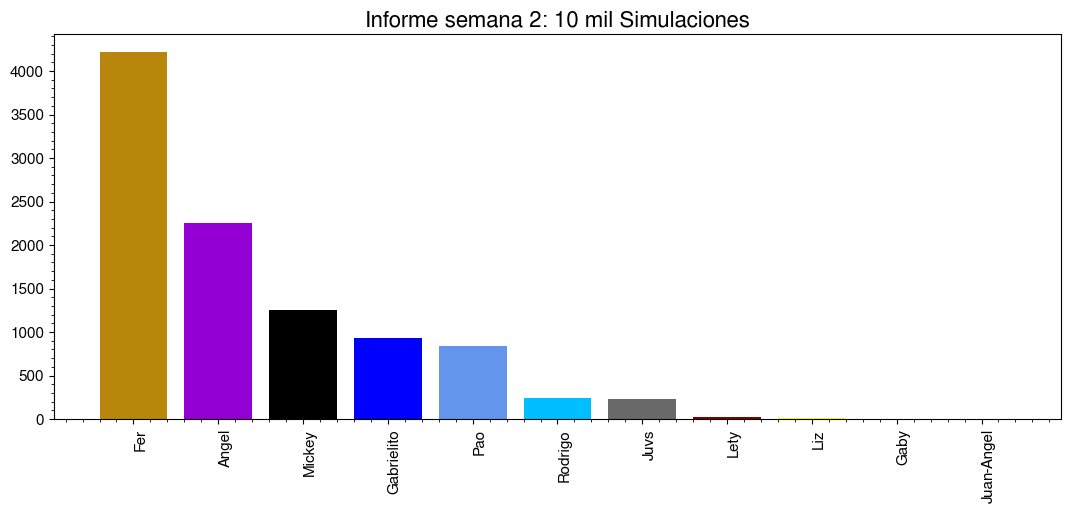

In [73]:
plt.figure(figsize=(13,5))
#plt.errorbar(wp.index.to_numpy(),(wp).to_numpy(),yerr=errs,fmt=".",capsize=3)
plt.bar(wp.index,wp,align="center",color=colors)
plt.xticks(rotation=90,ha="left")
plt.title("Informe semana 2: 10 mil Simulaciones")
plt.ylim(0,)
plt.show()

### Puntos esperados

In [50]:
def accumulate_results(name):
    results = []
    for i in ind:
        sample = chains[i]
        df = main.CreateMock(sample,jornada=2,maximos=maximos).puntuation(name)
        df[0] = actual["J1"].loc[name] #Agregando los resultados de cada jornada
        #df[1] = actual["J2"].loc[name] #para que no varíe el resultado ya definido
        results.append(df)
    return np.array(results)

In [51]:
def extract_most_prob_puntuation(name):
    results = accumulate_results(name)
    quantiles = []
    for i in range(accumulate_results(name).shape[1]):
        quantiles.append(np.quantile(results[:,i],q=[0.05,0.5,0.95]))
    return np.array(quantiles)

def cumulative_puntuation_mean(name):
    mosprob = extract_most_prob_puntuation(name)
    return np.cumsum(extract_most_prob_puntuation(name)[:,1])

def cumulative_puntuation_low(name):
    mosprob = extract_most_prob_puntuation(name)
    return np.cumsum(extract_most_prob_puntuation(name)[:,0])

def cumulative_puntuation_high(name):
    mosprob = extract_most_prob_puntuation(name)
    return np.cumsum(extract_most_prob_puntuation(name)[:,2])

In [52]:
med_w = []
high_w = []
low_w = []
for i in df.columns.to_numpy():
    med_w.append(np.rint(cumulative_puntuation_mean(i)[1]))
    high_w.append(np.rint(cumulative_puntuation_high(i)[1]))
    low_w.append(np.rint(cumulative_puntuation_low(i)[1]))

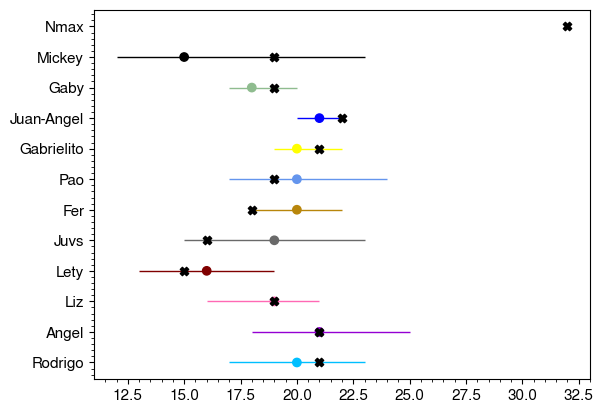

In [53]:
plt.scatter(med_w,df.columns.to_numpy(),color=colors,zorder=0)
plt.hlines(df.columns.to_numpy(),low_w,high_w,color=colors,capstyle="butt",zorder=0)
plt.scatter(actual["J2"]+actual["J1"],actual.index,color="black",label="Puntos obtenidos",marker="X",zorder=1)

plt.show()

In [45]:
med = []
high = []
low = []
for i in df.columns.to_numpy():
    med.append(np.rint(cumulative_puntuation_mean(i)[-1]))
    high.append(np.rint(cumulative_puntuation_high(i)[-1]))
    low.append(np.rint(cumulative_puntuation_low(i)[-1]))

In [46]:
colors = ["deepskyblue","darkviolet","hotpink","maroon","dimgray","darkgoldenrod","cornflowerblue","yellow","blue","darkseagreen","black"]

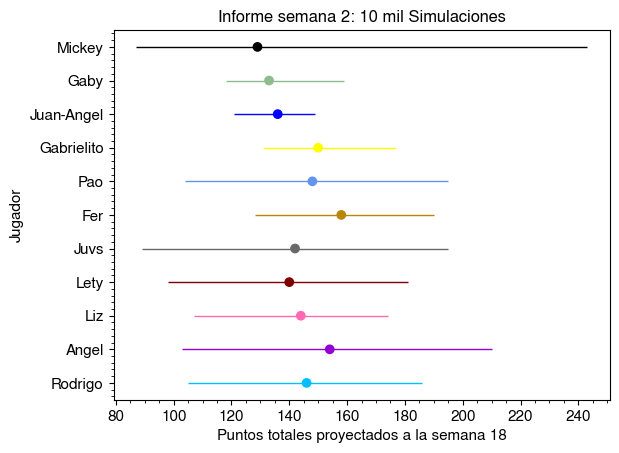

In [49]:
plt.scatter(med,df.columns.to_numpy(),color=colors)
plt.hlines(df.columns.to_numpy(),low,high,color=colors,capstyle="butt")
plt.title("Informe semana 2: 10 mil Simulaciones",fontsize=12)

plt.ylabel("Jugador")
plt.xlabel("Puntos totales proyectados a la semana 18")
plt.show()

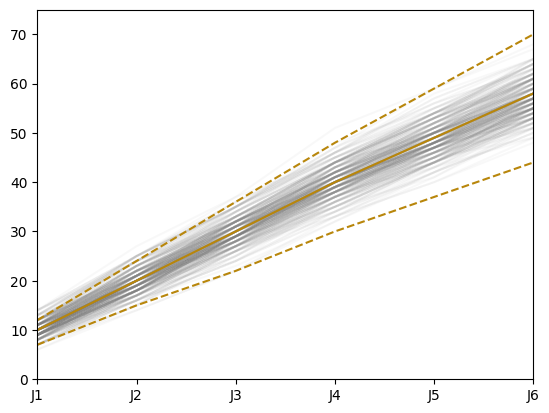

In [50]:
results = accumulate_results("Fer")
ind2 = np.random.randint(len(results),size=300)
for i in range(len(ind2)):
    plt.plot(df.index.to_numpy(),np.cumsum(results[ind2[i]]),color="gray",alpha=0.05)
plt.plot(df.index.to_numpy(),cumulative_puntuation_mean("Fer"),color="darkgoldenrod")
plt.plot(df.index.to_numpy(),cumulative_puntuation_low("Fer"),color="darkgoldenrod",ls="--")
plt.plot(df.index.to_numpy(),cumulative_puntuation_high("Fer"),color="darkgoldenrod",ls="--")
plt.xlim(df.index.to_numpy()[0],df.index.to_numpy()[5])
plt.ylim(0,75)
plt.show()

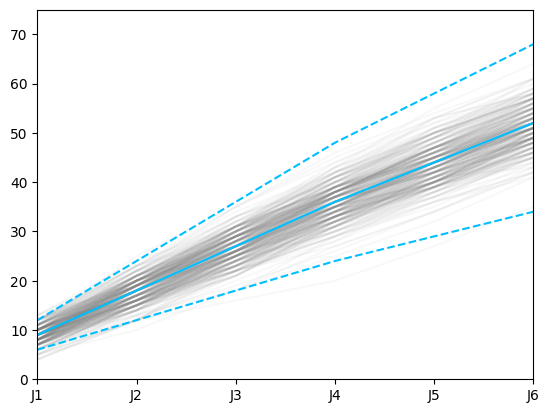

In [309]:
ind2 = np.random.randint(len(results),size=300)
for i in range(len(ind2)):
    plt.plot(df.index.to_numpy(),np.cumsum(accumulate_results("Rodrigo")[ind2[i]]),color="gray",alpha=0.05)

plt.plot(df.index.to_numpy(),cumulative_puntuation_mean("Rodrigo"),color="deepskyblue")
plt.plot(df.index.to_numpy(),cumulative_puntuation_low("Rodrigo"),color="deepskyblue",ls="--")
plt.plot(df.index.to_numpy(),cumulative_puntuation_high("Rodrigo"),color="deepskyblue",ls="--")
plt.xlim(df.index.to_numpy()[0],df.index.to_numpy()[5])
plt.ylim(0,75)
plt.show()